# Exploratory Data Analysis

### Gene expression analysis of human lung cancer and control samples



I chose this dataset to explore gene expression differences between lung cancer (tumoral) and healthy (normal) samples. There are total 90 samples and 54675 gene probes. Therefore, it provides a rich source of data to perform differential gene expression analysis, dimensionality reduction, and clustering.


#### Importing all the libraries 

In [144]:
# Importing all the libraries 
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
import statsmodels.stats.multitest as smm
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score

#### Loading the Dataset

In [145]:
data = pd.read_csv('Lung_GSE18842.csv', index_col=0)

In [146]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 6947 to 7037
Columns: 54676 entries, type to AFFX-TrpnX-M_at
dtypes: float64(54675), object(1)
memory usage: 37.5+ MB
None
       1007_s_at    1053_at     117_at     121_at  1255_g_at    1294_at  \
count  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
mean   10.274764   7.500893   7.435259   7.098009   3.472165   7.633386   
std     0.832922   0.693790   1.482587   0.341756   0.387170   0.823031   
min     8.431264   6.404995   4.985703   6.459663   2.967113   5.713103   
25%     9.702311   7.023393   6.354679   6.852653   3.233656   7.029655   
50%     9.968634   7.250462   7.051204   7.045890   3.377492   7.880279   
75%    10.995121   7.992496   8.408398   7.316777   3.604726   8.297460   
max    12.465030   9.299453  11.343542   8.153428   5.891248   9.051629   

         1316_at    1320_at  1405_i_at    1431_at  ...  AFFX-r2-Ec-bioD-3_at  \
count  90.000000  90.000000  90.000000  90.000000  ...          

There are **90 samples (rows)** and **54675 genes (columns).**

## Data Preprocessing

#### Missing Values

In [147]:
# Check for missing values
print(data.isnull().sum())

type               0
1007_s_at          0
1053_at            0
117_at             0
121_at             0
                  ..
AFFX-ThrX-5_at     0
AFFX-ThrX-M_at     0
AFFX-TrpnX-3_at    0
AFFX-TrpnX-5_at    0
AFFX-TrpnX-M_at    0
Length: 54676, dtype: int64


As there are no missing values (NaNs) in the dataset, we do not need to **impute** the dataset. 

#### Sample distribution and outliers

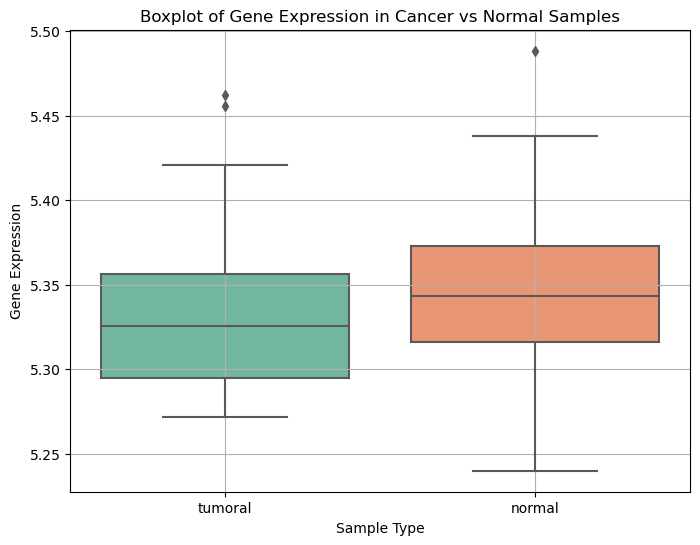

In [148]:
# Calculate the mean expression across all genes for each sample
data['Gene Expression'] = data.drop(columns='type').mean(axis=1)

# Create a boxplot to compare the overall mean expression between cancer and normal samples
plt.figure(figsize=(8, 6))
sns.boxplot(x='type', y='Gene Expression', data=data, palette='Set2')
plt.title('Boxplot of Gene Expression in Cancer vs Normal Samples')
plt.xlabel('Sample Type')
plt.ylabel('Gene Expression')
plt.grid(True)
plt.show()


#### Log Transformation
To address outliers, applying **Log Transformation**. It addresses the non-positive values, by adding a small constant.

In [149]:
# Handle zeros or negative values by adding a small constant (1e-9)
data_log2 = data.copy()
data_log2.iloc[:, 1:] = np.log2(data_log2.iloc[:, 1:] + 1e-9)


#### Z-score normalization
Applied after log transformation, **Z-score normalization** applied to ensure that the data is standardized.

In [150]:
# Z-score normalization
normalized_data = data_log2.copy()
normalized_data.iloc[:, 1:] = stats.zscore(normalized_data.iloc[:, 1:], axis=0)

normalized_data['type'] = data_log2['type']

print("\nLog2 Transformed and Z-score Normalized Data:")
print(normalized_data.head())


Log2 Transformed and Z-score Normalized Data:
            type  1007_s_at   1053_at    117_at    121_at  1255_g_at  \
samples                                                                
6947     tumoral   0.973189  1.353824 -1.104744 -0.580640   0.010105   
6949     tumoral   0.871478  1.876874  1.130538  0.542893   0.190493   
6951     tumoral  -0.499512 -0.679189  0.107859 -0.440632  -0.827526   
6952     tumoral   1.221693  0.850360 -1.332681  0.792258   0.618574   
6954     tumoral  -0.162375  0.224256  1.160873 -0.455914   0.925588   

          1294_at   1316_at   1320_at  1405_i_at  ...  AFFX-r2-Ec-bioD-5_at  \
samples                                           ...                         
6947    -1.185704 -0.797376 -1.152575   0.753898  ...              0.742473   
6949    -1.294825 -1.327203 -1.601128  -0.629864  ...              0.716466   
6951     0.902234  1.635464 -1.224028   1.285519  ...              1.303101   
6952    -1.792804 -0.142480 -0.732353  -0.404725  ...

## Dimensionality Reduction with PCA

Variance by PC1: 0.1620
Variance by PC2: 0.1137


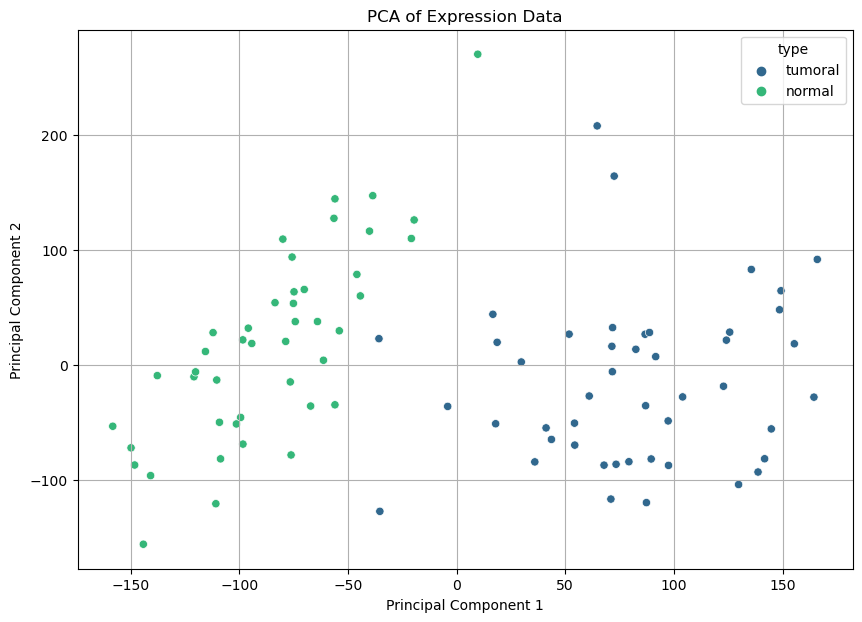

In [151]:
scaler = StandardScaler()
data_for_pca = normalized_data.drop(columns='type')
scaled_data_pca = scaler.fit_transform(data_for_pca)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data_pca)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['type'] = normalized_data['type'].values

variance = pca.explained_variance_ratio_

print(f'Variance by PC1: {variance[0]:.4f}')
print(f'Variance by PC2: {variance[1]:.4f}')

# Visualize
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='type', palette='viridis')
plt.title('PCA of Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

### Interpretation:

- PC1 and PC2 explain around **27.57% of the total variance in the data**, which means there is still a lot of variability that is not captured by these two components alone.
- **Normal samples cluster more tightly**, suggesting that these samples may have more **consistent gene expression** profiles across individuals
- **Tumoral samples are more spread out**, possibly due to **heterogeneity** in the tumor types, stages, or other biological differences between the tumor samples


## Dimensionality Reduction with UMAP

/Users/vaishnaveethote/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


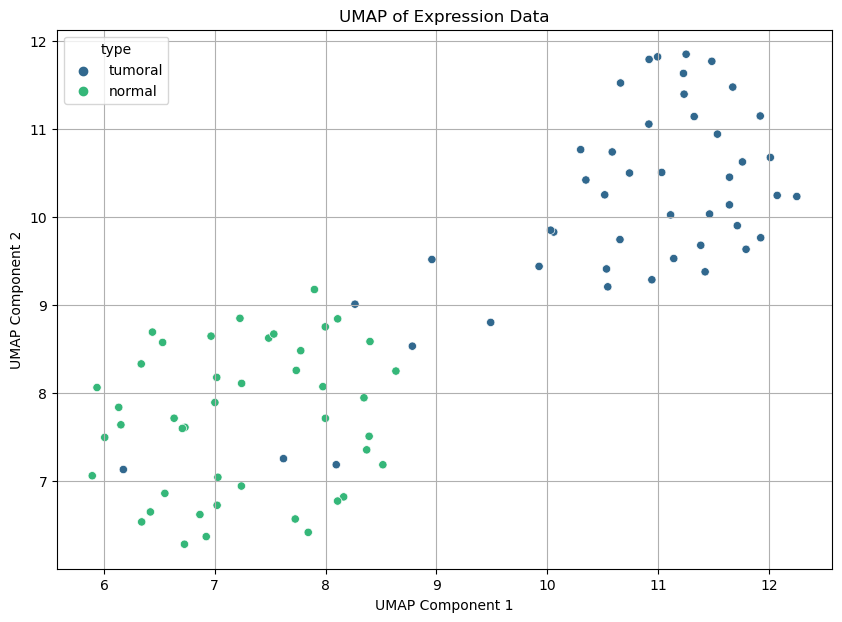

In [152]:
# Initialize UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.3, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(scaled_data_pca) 

umap_df = pd.DataFrame(data=umap_result_default, columns=['UMAP1', 'UMAP2'])
umap_df['type'] = normalized_data['type'].values

# Visualize
plt.figure(figsize=(10, 7))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='type', palette='viridis')
plt.title('UMAP of Expression Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()


### Interpretation
- I found that using **n_neighbors=15 and min_dist=0.3** provided a good balance between preserving local structure and revealing global patterns.
- Similar to the PCA plot, **Normal samples** are more **homogeneously** distributed, with tighter clustering. This may indicate that there is less variability in gene expression among healthy individuals.
- The **tumoral samples** form a distinct cluster, particularly along UMAP Component 1, which suggests that the gene expression changes associated with the tumor state are **heterogenous.**

- With the results, we could see that **UMAP separates two samples more efficiently than PCA**.


## Differential Gene Expression

In [153]:
# Separate tumoral and normal samples based on the 'type' column
tumoral_samples = normalized_data[normalized_data['type'] == 'tumoral'].drop('type', axis=1)
normal_samples = normalized_data[normalized_data['type'] == 'normal'].drop('type', axis=1)

# Calculating mean expression for each gene in tumoral and normal samples
tumoral_mean = tumoral_samples.mean(axis=0)
normal_mean = normal_samples.mean(axis=0)

# T-tests for each gene
p_values = []
t_statistics = []

for gene in tumoral_samples.columns:
    t_stat, p_val = stats.ttest_ind(tumoral_samples[gene], normal_samples[gene], equal_var=False)
    t_statistics.append(t_stat)
    p_values.append(p_val)
    
# Adjust for multiple testing (Benjamini-Hochberg correction)
adjusted_p_values = smm.multipletests(p_values, method='fdr_bh')[1]

results = pd.DataFrame({
    'Gene': tumoral_samples.columns,
    'T-stat': t_statistics,
    'P-value': p_values,
    'Adjusted P-value': adjusted_p_values
})

significant_genes = results[results['Adjusted P-value'] < 0.05].copy()

# Calculating log2 fold change (log2FC)
tumoral_mean_clipped = tumoral_mean.clip(lower=1e-9)
normal_mean_clipped = normal_mean.clip(lower=1e-9)
log2_fold_change = np.log2(tumoral_mean_clipped / normal_mean_clipped)

significant_genes['Log2FoldChange'] = log2_fold_change.loc[significant_genes['Gene']].values

significant_genes = significant_genes.sort_values('Log2FoldChange', ascending=False)


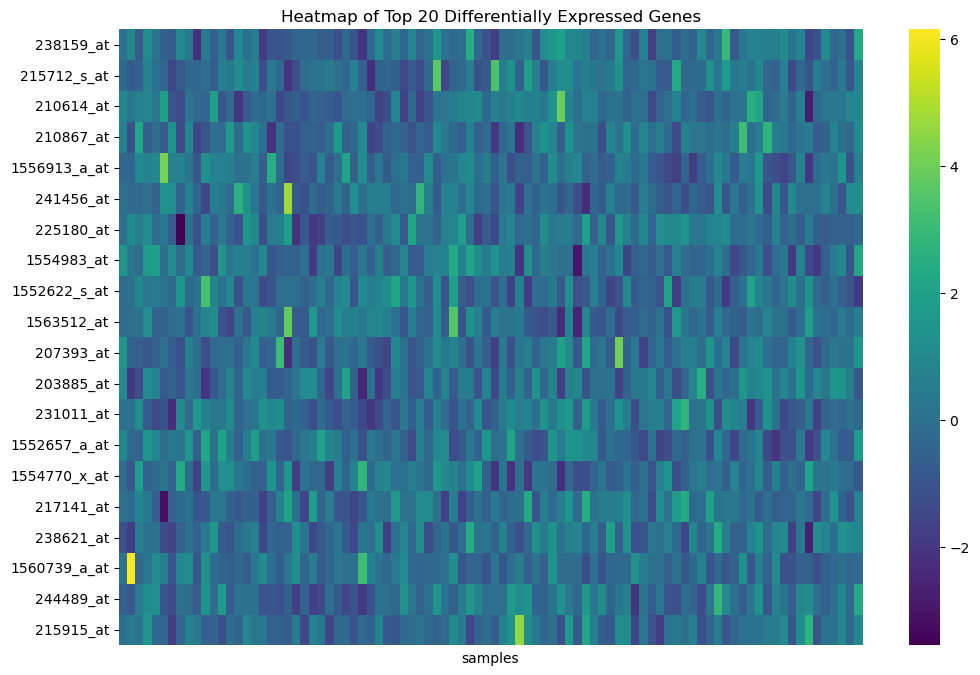

47408       238159_at
25005     215712_s_at
19999       210614_at
20242       210867_at
3315     1556913_a_at
50705       241456_at
34437       225180_at
1981       1554983_at
258      1552622_s_at
7241       1563512_at
16836       207393_at
13332       203885_at
40265       231011_at
281      1552657_a_at
1816     1554770_x_at
26428       217141_at
47870       238621_at
5517     1560739_a_at
53739       244489_at
25208       215915_at
Name: Gene, dtype: object


In [154]:
# Visualization - Heatmap 
top_genes = significant_genes.nlargest(20, 'Adjusted P-value')['Gene']  #top 20 genes 
top_gene_data = normalized_data[top_genes]

plt.figure(figsize=(12, 8))
sns.heatmap(top_gene_data.T, cmap='viridis', xticklabels=False, yticklabels=top_genes)
plt.title('Heatmap of Top 20 Differentially Expressed Genes')
plt.show()

print(top_genes)

### Interpretation

   - The expression patterns are relatively uniform for most genes, with sporadic high expression (yellow) and low expression (purple) observed in some specific genes and samples.

   - Gene **1560739_a_at**, show more variability in expression, exhibiting yellowish regions. This probe could be for the **gene UBE3C** which is known to inhibit apoptosis. So this gene could be upregulated in tumoral samples.
  

## Clustering on PCA-reduced data

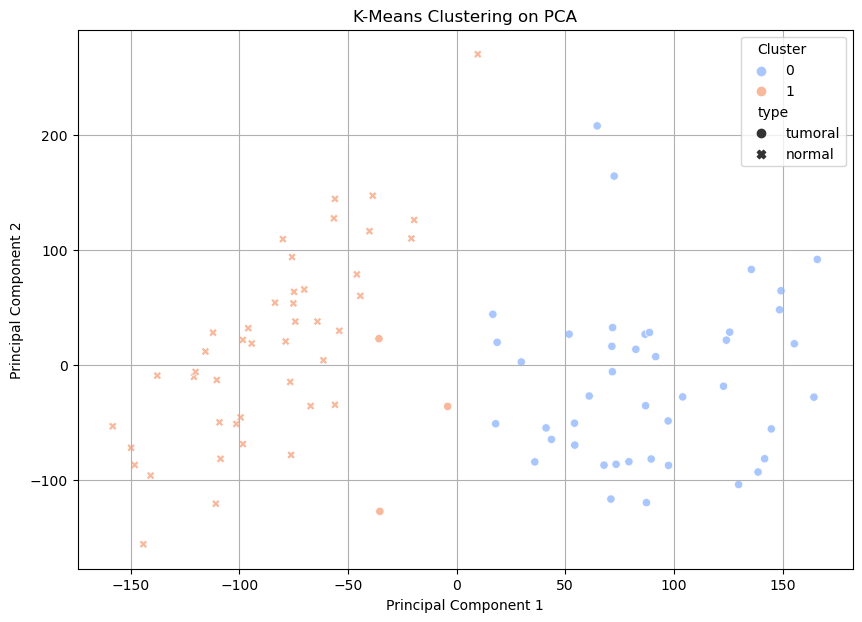

K-Means Clustering on PCA Results:
Accuracy: 0.03
Adjusted Rand Index (ARI): 0.87


In [155]:
# Apply KMeans clustering on the PCA results
kmeans_pca = KMeans(n_clusters=2, random_state=42)  # 2 clusters for disease and healthy
kmeans_pca_labels = kmeans_pca.fit_predict(pca_result)

# Add the KMeans cluster labels to the PCA DataFrame
pca_df['Cluster'] = kmeans_pca_labels

# Visualize the clusters in PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='coolwarm', style='type')
plt.title('K-Means Clustering on PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Evaluate clustering alignment with actual 'type' (disease vs. healthy)
# For this, we'll convert 'type' to binary values: tumoral = 1, normal = 0
true_labels = normalized_data['type'].apply(lambda x: 1 if x == 'tumoral' else 0)

# Calculate accuracy and Adjusted Rand Index (for unsupervised clustering)
accuracy = accuracy_score(true_labels, kmeans_pca_labels)
ari = adjusted_rand_score(true_labels, kmeans_pca_labels)

print(f'K-Means Clustering on PCA Results:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Adjusted Rand Index (ARI): {ari:.2f}')

### Interpretation:

- The accuracy of the clustering is very low **(0.03)**, which indicates that the K-Means model does not classify the samples well based on the PCA components.
- However, the **Adjusted Rand Index (ARI) is 0.87**, indicating that the clustering is fairly consistent with the true sample labels despite the low accuracy score. 

## Clustering on UMAP-reduced data

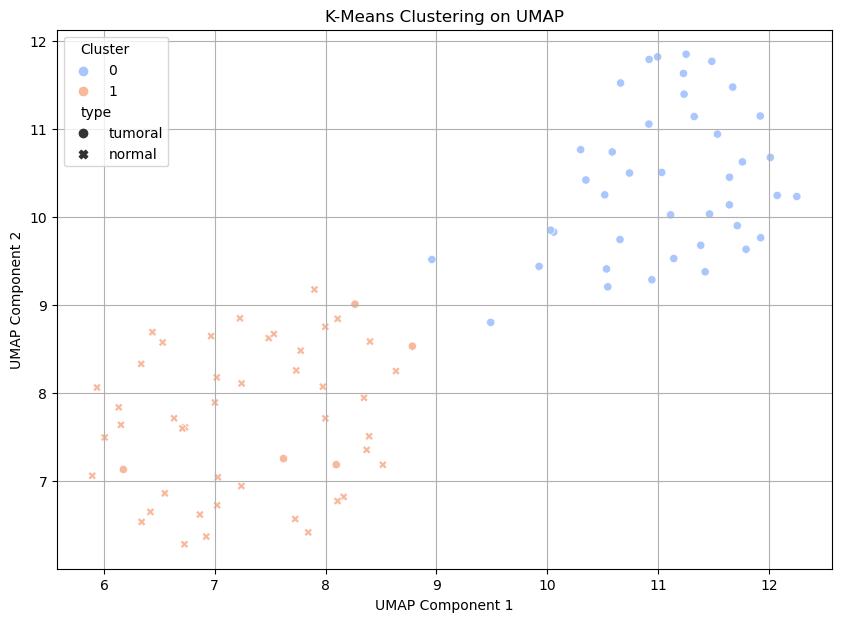

K-Means Clustering on UMAP Results:
Accuracy: 0.06
Adjusted Rand Index (ARI): 0.79


In [156]:
# Apply KMeans clustering on UMAP results
kmeans_umap = KMeans(n_clusters=2, random_state=42)
kmeans_umap_labels = kmeans_umap.fit_predict(umap_result_default)

# Add the KMeans cluster labels to the UMAP DataFrame
umap_df_default['Cluster'] = kmeans_umap_labels

# Visualize the clusters in UMAP space
plt.figure(figsize=(10, 7))
sns.scatterplot(data=umap_df_default, x='UMAP1', y='UMAP2', hue='Cluster', palette='coolwarm', style='type')
plt.title('K-Means Clustering on UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()

# Evaluate clustering alignment with actual 'type'
accuracy_umap = accuracy_score(true_labels, kmeans_umap_labels)
ari_umap = adjusted_rand_score(true_labels, kmeans_umap_labels)

print(f'K-Means Clustering on UMAP Results:')
print(f'Accuracy: {accuracy_umap:.2f}')
print(f'Adjusted Rand Index (ARI): {ari_umap:.2f}')

### Interpretation

- The accuracy of the clustering is quite low **(0.06).**
- The **ARI score is 0.79**, which is relatively high. This suggests that although the clusters do not perfectly correspond to the true labels, there is still a good level of agreement between the clustering structure and the true grouping of samples. 


__________________________________________________________________________________________________________________

## Conclusion

This analysis compares the gene expression of tumoral and normal lung cancer samples, using a curated dataset with 90 samples for 54,675 genes. Different preprocessing techniques had been carried out, such as log transformation and z-score normalization, in order to account for data variability and different scales. The results of both PCA and UMAP presented clear patterns of dimensionality reduction: normal samples clustered tightly, indicative of consistent gene expression, while tumoral samples were more spread out, presumably reflecting tumor heterogeneity. Unlike PCA, **UMAP separated sample types with a much better resolution**. Differential gene expression identified significant genes, while the top 20 differentially expressed genes, such as **UBE3C**, allowed proper biological insight into the possible functions of these genes in tumor progression. 
In contrast, clustering performed on the data after reduction with PCA and UMAP yielded poor accuracy values, 0.03 and 0.06, respectively, but high ARI values, 0.87 and 0.79, respectively, hence pointing toward the fact that while cluster assignments did not perfectly match true labels, there is significant agreement between these clustering results and underlying biological classes. Overall, this analysis demonstrates the utility of dimensionality reduction and clustering techniques for identifying gene expression patterns.


#### My Observation

- The referenced paper emphasizes **KRT15, PKP1, and DSG3** as key markers in nonsmall cell lung cancer (NSCLC), validated through qPCR and robust statistical methods. My analysis indicates UBE3C as one of the key marker might not hold as much biological significance for NSCLC as the other genes validated in the study.
- The paper used **microarray data combined with qPCR validation** to confirm gene expression changes, while my analysis relied on statistical methods like **t-tests and multiple testing corrections (Benjamini-Hochberg).** 
- The paper also aimed to identify specific markers of tumor stage and differentiation, whereas my analysis looked more broadly at **tumoral vs. normal samples** without considering these factors.
- Conclusion is that the results differ because of differences in **methodology, sample preprocessing, gene selection criteria, and biological factors.**




## References

- Dataset : GEO Accession Number - GSE18842 https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE18842 

- Curated Dataset :CuMiDa, An Extensively Curated Microarray Database https://sbcb.inf.ufrgs.br/cumida#datasets

- Sanchez-Palencia A, Gomez-Morales M, Gomez-Capilla JA, Pedraza V, Boyero L, Rosell R, Fárez-Vidal ME. Gene expression profiling reveals novel biomarkers in nonsmall cell lung cancer. Int J Cancer. 2011 Jul 15;129(2):355-64. doi: 10.1002/ijc.25704. Epub 2010 Nov 28. PMID: 20878980.

